In [2]:
import velocity_metrics.lagrangian.drifters as drifters
import velocity_metrics.lagrangian.cumulative_distance as sde
import velocity_metrics.utils.constant as const  
import os
import warnings
import sys
import datetime
warnings.filterwarnings("ignore")
#sys.path.append('/Odyssey/private/t22picar/2024_DC_WOC-ESA/')
import json

import netCDF4
import numpy
import matplotlib
# import cartopy
import glob
import os
import sys
import datetime
from matplotlib import pyplot
import pickle
import gzip
from tqdm import tqdm
from typing import Optional, Tuple
import logging
logger = logging.getLogger(__name__)
import matplotlib.pyplot
import cartopy.crs as ccrs

box_cal = [-135, -115, 20, 50]
box_med = [-5.6, 16.8, 34.6, 44.6]
box_gs = [-80, -43, 25, 46.5 ]
box_agulhas = [11, 35, -44, -30]
box_NA = [-40, 0, 48, 68]

In [3]:
dico_color = {
    "globcurrent_15m_4th": "b",
    "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet": "g",
    "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet": "g",
    "neurost_sst_ssh_15m_10th": "violet",
    # Ajoutez d'autres correspondances ici
}

In [4]:
from plot_lagrangian import *

In [5]:
def plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_neurost,dic_drif,box):
    lon_min, lon_max, lat_min, lat_max = box
    alpha=0.4
    map_back = get_sst_L4_8th(date_target,box)
    list_advection, dic_all = get_list_advection(date_target,fictive_traj)
    list_advection_neurost, dic_all_neurost = get_list_advection(date_target,fictive_traj_neurost)

    figure = pyplot.figure(figsize=(8, 8))
    proj=ccrs.PlateCarree()

    for advection,advection_neurost in zip(list_advection,list_advection_neurost):
        
        #print(advection)

        lon_f_n, lat_f_n, hrtime_n, dic_attr_n,lon_d,lat_d = get_fictive_traj(advection_neurost,dic_all_neurost,dic_drif)

        lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,dic_drif)
        
        #print(hrtime)
        
        proj=ccrs.PlateCarree()
        
        ax0 = pyplot.subplot(111, projection=proj)


        extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                    numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
        
        gl = ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.3, xlocs=range(-180, 181, 4), ylocs=range(-90, 91, 4))
            # adjust labels to taste
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = True
        gl.left_labels = True

        ax0.add_feature(
        cfeature.LAND,
        facecolor='lightgray',  # Couleur de remplissage
        edgecolor='black',      # Couleur des bordures (optionnel)
        zorder=2                # Ordre de dessin (0 = en arrière-plan)
        )

        ax0.coastlines(resolution='10m', lw=0.5)
        
        for pa in range(0, numpy.shape(lon_f)[1], 1):
            ax0.plot(lon_f[:, pa], lat_f[:, pa], dico_color.get(dic_attr["data_type"],'b'), transform=proj,alpha=alpha,zorder=5)
            ax0.plot(lon_f_n[:, pa], lat_f_n[:, pa], dico_color.get(dic_attr_n["data_type"],'g'), transform=proj,alpha=alpha,zorder=5)
        
        """"
        for pa in range(0, numpy.shape(lon_f)[1], 1):
            ax0.plot(lon_f[:, pa], lat_f[:, pa], dico_color.get(dic_attr["data_type"],'g'), transform=proj,alpha=alpha,zorder=5)

        for pa in range(0, numpy.shape(lon_f_n)[1], 1):
            ax0.plot(lon_f_n[:, pa], lat_f_n[:, pa], dico_color.get(dic_attr_n["data_type"],'g'), transform=proj,alpha=alpha,zorder=5)
        """

        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1,zorder=10)
        ax0.scatter(lon_d[0],lat_d[0], transform=proj,alpha=1,c='k',s=40,marker='o',zorder=10)
        ax0.scatter(lon_d[-1],lat_d[-1], transform=proj,alpha=1,c='k',s=40,marker='^',zorder=10)
    
    sst_cm = ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)

    ax0.plot(lon_f[0, 0], lat_f[0, 0], dico_color.get(dic_attr["data_type"],'b'), transform=proj,alpha=1,label=dico_label.get(dic_attr["data_type"], dic_attr["data_type"]))
    ax0.plot(lon_f_n[0, 0], lat_f_n[0, 0], dico_color.get(dic_attr_n["data_type"],'g'), transform=proj,alpha=1,label=dico_label.get(dic_attr_n["data_type"], dic_attr_n["data_type"]))
    ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1,label="Drifter")

    ax0.set_ylim(lat_min,lat_max)
    ax0.set_xlim(lon_min,lon_max)

    ax0.legend()
    ax0.set_title(f"First date advection : {date_target}")

    #get size and extent of axes:
    axpos = ax0.get_position()
    pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
    pos_y = axpos.y0
    cax_width = 0.02
    cax_height = axpos.height

    pos_cax = figure.add_axes([pos_x,pos_y,cax_width,cax_height])
    cbar=matplotlib.pyplot.colorbar(sst_cm, cax=pos_cax, orientation='vertical')
    # Définir les ticks comme des entiers
    ticks = numpy.arange(int(cbar.vmin)+1, int(cbar.vmax) + 1, 5)
    cbar.set_ticks(ticks)
    cbar.set_label("SST at released day + 5d (K)")
        
    #cbar = matplotlib.pyplot.colorbar(sst_cm, ax=ax0, orientation='vertical', pad=0.08,shrink=0.35)

In [6]:
base_output="../../"
depth=15
depth_formatted = "{:02}".format(depth)
input_dict = f'{base_output}metric/dictionary/'
input_drifter = "/Odyssey/private/t22picar/data/drifters/AOML/"
drifter_list = [input_drifter + f'Drifters_AOML_GL_{depth_formatted}m_20190101T000000Z_20200101T000000Z.pyo.gz']

input_lagrangian_position = '/Odyssey/private/t22picar/data/drifters/AOML/json/'
region="Agulhas"
#path_drifter_position = input_lagrangian_position + f'Fictive_pos_Drifters_AOML_region_{region}_{depth_formatted}m_20190101T000000Z_20200101T000000Z.json' 
path_drifter_param = input_dict + 'drifters_parameters.ini'

xp_name="globcurrent_15m_4th"#"neurost_sst_ssh_15m_10th"
xp_name_2="unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet" #"unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs" #"unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost"

type_metric = "metric_15m"
fictive_traj = f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name}/{type_metric}/{region}/{xp_name}_region_{region}_dep1.pyo.gz"
fictive_traj_2=f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name_2}/{type_metric}/{region}/{xp_name_2}_region_{region}_dep1.pyo.gz"

if 'gz' in os.path.splitext(drifter_list[0])[-1]:
    with gzip.open(drifter_list[0], 'rb') as f:
        dic_drif = pickle.load(f)

number of drifter : 4
number of drifter : 4


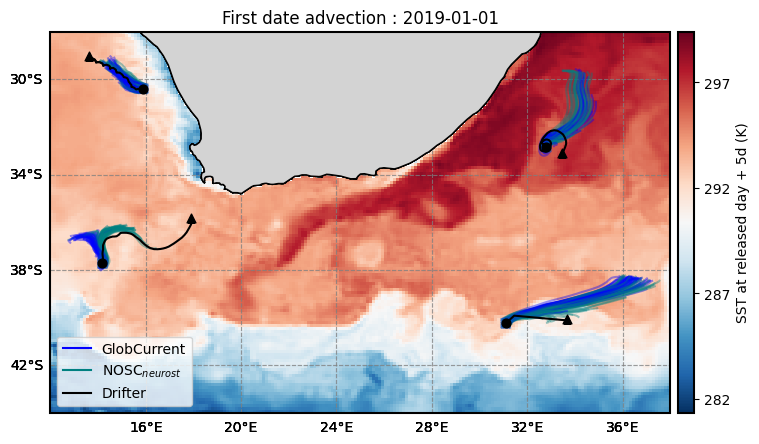

In [7]:
box_agulhas = [12, 38, -44, -28]
date_target = "2019-01-01"
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_agulhas)
#matplotlib.pyplot.savefig("/Odyssey/private/t22picar/plot_article/figures/Lagrangian_traj_AG.png",dpi=300,bbox_inches='tight')

number of drifter : 21
number of drifter : 21
Pb with hrtime
Pb with hrtime
Pb with hrtime
Pb with hrtime


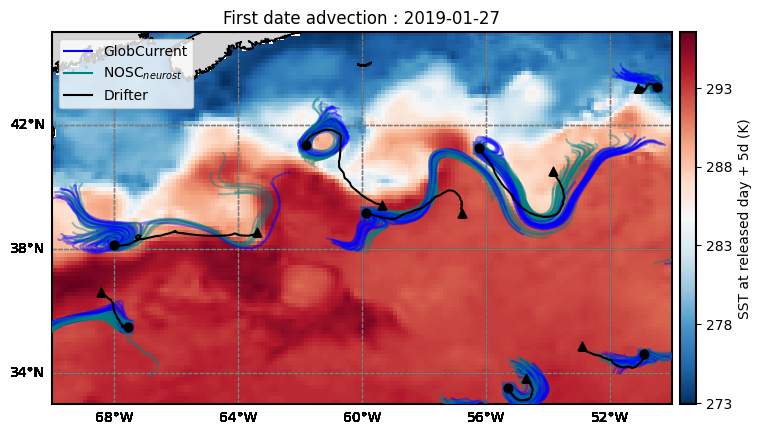

In [11]:
base_output="../../"
depth=15
depth_formatted = "{:02}".format(depth)
input_dict = f'{base_output}metric/dictionary/'
input_drifter = "/Odyssey/private/t22picar/data/drifters/AOML/"
drifter_list = [input_drifter + f'Drifters_AOML_GL_{depth_formatted}m_20190101T000000Z_20200101T000000Z.pyo.gz']

input_lagrangian_position = '/Odyssey/private/t22picar/data/drifters/AOML/json/'
region="GulfStream"
path_drifter_position = input_lagrangian_position + f'Fictive_pos_Drifters_AOML_region_{region}_{depth_formatted}m_20190101T000000Z_20200101T000000Z.json' 
path_drifter_param = input_dict + 'drifters_parameters.ini'

xp_name="globcurrent_15m_4th"#"neurost_sst_ssh_15m_10th"
xp_name_2="unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet" #"unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost"

type_metric = "metric_15m"
fictive_traj = f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name}/{type_metric}/{region}/{xp_name}_region_{region}_dep1.pyo.gz"
fictive_traj_2=f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name_2}/{type_metric}/{region}/{xp_name_2}_region_{region}_dep1.pyo.gz"

if 'gz' in os.path.splitext(drifter_list[0])[-1]:
    with gzip.open(drifter_list[0], 'rb') as f:
        dic_drif = pickle.load(f)
        
box_gs = [-71, -52, 33, 45 ]
box_gs = [-70, -50, 33, 45 ]
date_target = "2019-01-27" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box=box_gs)
#pyplot.savefig(f"/Odyssey/private/t22picar/plot_article/figures/Lagrangian_traj_GS.png", dpi = 300,bbox_inches='tight')

In [12]:
base_output="../../"
depth=15
depth_formatted = "{:02}".format(depth)
input_dict = f'{base_output}metric/dictionary/'
input_drifter = "/Odyssey/private/t22picar/data/drifters/AOML/"
drifter_list = [input_drifter + f'Drifters_AOML_GL_{depth_formatted}m_20190101T000000Z_20200101T000000Z.pyo.gz']

input_lagrangian_position = '/Odyssey/private/t22picar/data/drifters/AOML/json/'
region="Hawai"
path_drifter_position = input_lagrangian_position + f'Fictive_pos_Drifters_AOML_region_{region}_{depth_formatted}m_20190101T000000Z_20200101T000000Z.json' 
path_drifter_param = input_dict + 'drifters_parameters.ini'

xp_name_2="unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet"
xp_name="globcurrent_15m_4th" #"GC_15m_4th_h"
#xp_name="neurost_sst_ssh_15m_10th"

if region=="T1":
    region="Agulhas"

fictive_traj = f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name}/metric_15m/{region}/{xp_name}_region_{region}_dep1.pyo.gz"
fictive_traj_2=f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name_2}/metric_15m/{region}/{xp_name_2}_region_{region}_dep1.pyo.gz"

if 'gz' in os.path.splitext(drifter_list[0])[-1]:
    with gzip.open(drifter_list[0], 'rb') as f:
        dic_drif = pickle.load(f)

number of drifter : 39
number of drifter : 39
Pb with hrtime
Pb with hrtime


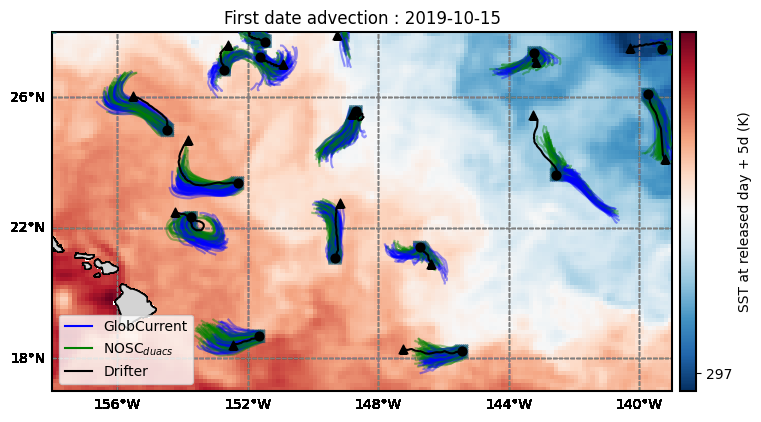

In [10]:
box_HW = [-158, -139, 17, 28]

date_target = "2019-10-15" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

#pyplot.savefig(f"/Odyssey/private/t22picar/plot_article/figures/Lagrangian_traj_HW.png", dpi = 300,bbox_inches='tight')
